In [1]:
import numpy as np
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.nn.parameter import Parameter

%matplotlib inline
import pylab as pl

from IPython import display
from copy import deepcopy
from skimage.transform import resize
from PIL import Image

In [2]:
# Set Important Values

data = '/data/mini_inat/'
gpu = 1
torch.cuda.set_device(gpu)
workers = 8
epoch = 10
start_epoch = 0
vbity = 20

way = 20
evalway = 5
trainshot = 5
testshot = 15

In [4]:
# Make Model

class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize)
        )
        
    def forward(self, inp):
        return self.layers(inp)

class PROTO(nn.Module):
    def __init__(self):
        super(PROTO, self).__init__()
        self.process1 = nn.Sequential(
            Block(3,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64)
        )
        self.process2 = nn.Sequential(
            Block(3,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64)
        )
        self.pool = nn.AvgPool2d(10)
        self.sm = nn.LogSoftmax(dim=-1)
        
    def forward(self, inp, way, supshot):
        support = self.pool(self.process1(inp[:way*supshot,:,:,:])).squeeze()
        query = self.pool(self.process2(inp[way*supshot:,:,:,:])).squeeze()
        
        support = support.view(way,supshot,-1)
        support = torch.mean(support, 1).view(support.size(0),-1)
        distmat = torch.sum((support.unsqueeze(0)-query.unsqueeze(1))**2,2).squeeze().neg()
        probs = self.sm(distmat)
        return probs

model = PROTO().cuda(device = gpu)
optimizer = optim.Adam(model.parameters(), lr=.001)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda x: 1/(2**x))
criterion = nn.NLLLoss().cuda(device = gpu)
cudnn.benchmark = True

nweights = sum([i.numel() for i in list(model.parameters())])
print(nweights," parameters in neural net.")

226176  parameters in neural net.


In [5]:
# Load Training/Testing Data

d_train = torch.load(data+'train_boxes.pth')
d_test = torch.load(data+'val_boxes.pth')
d_boxes = torch.load(data+'box_coords.pth')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4905, 0.4961, 0.4330],std=[0.1737, 0.1713, 0.1779])
    ])

def load_transform(path, pathdict, boxdict, transform, size, flipping, masking):
    flip = np.random.choice([True, False])
    with open(path, 'rb') as f:
        p = Image.open(f)
        p = p.convert('RGB')
    w,h = p.size
    p = p.resize((size, size), Image.BILINEAR)
    if flip and flipping:
        p = p.transpose(Image.FLIP_LEFT_RIGHT)
    t = transform(p)
    if masking:
        mask = np.zeros((h,w))
        boxes = pathdict[path]
        for b in boxes:
            box = boxdict[b]
            xmin = box[0]
            xmax = box[2]+xmin
            ymin = box[1]
            ymax = box[3]+ymin
            if not flip or not flipping:
                mask[ymin:ymax, xmin:xmax] = 1
            else:
                mask[ymin:ymax, w-xmax:w-xmin] = 1
        mask = resize(mask, (size,size), mode='constant', cval=0)
        t = torch.cat([t, torch.FloatTensor(mask).unsqueeze(0)], dim=0)
    return t

class ProtoSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, data_source, way):
        iddict = dict()
        for i,(_,cat) in enumerate(data_source.imgs):
            if cat in iddict:
                iddict[cat].append(i)
            else:
                iddict[cat] = [i]
        self.iddict = iddict
        self.way = way
        
    def __iter__(self):
        # Build new dictionary, shuffle entries
        trackdict = deepcopy(self.iddict)
        for key in trackdict:
            np.random.shuffle(trackdict[key])
        # Choose categories, sample, eliminate small categories
        idlist = []
        while len(trackdict.keys()) >= self.way:
            cats = np.random.choice(list(trackdict.keys()), size=self.way, replace=False)
            for cat in cats:
                for _ in range(trainshot):
                    idlist.append(trackdict[cat].pop())
            for cat in cats:
                for _ in range(testshot):
                    idlist.append(trackdict[cat].pop())
                if len(trackdict[cat]) < trainshot+testshot:
                    trackdict.pop(cat)
            yield idlist
            idlist = []

train_dataset = datasets.ImageFolder(
    data+'train', 
    loader = lambda x: load_transform(x, d_train, d_boxes, transform, 84, True, False))
test_dataset = datasets.ImageFolder(
    data+'val',
    loader = lambda x: load_transform(x, d_test, d_boxes, transform, 84, False, False))
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_sampler = ProtoSampler(train_dataset, way),
    num_workers = workers,
    pin_memory = True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_sampler = ProtoSampler(test_dataset, evalway),
    num_workers = workers,
    pin_memory = True)
print('Data loaded!')

Data loaded!


In [6]:
# Define the Procedures

def train(epoch, gpu, vbity):
    model.train()
    targ = Variable(torch.LongTensor([i//testshot for i in range(testshot*way)])).cuda(
        device = gpu, async=True)
    allloss = 0
    for i, (inp, _) in enumerate(train_loader):
        inp = Variable(inp).cuda(device = gpu, async=True)
#         inp[way*trainshot:,-1,:,:].zero_()
        
        model.zero_grad()
        out = model(inp, way, trainshot)
        loss = criterion(out, targ)
        loss.backward()
        optimizer.step()
        
        allloss += loss.item()
        if i%vbity == 0:
            print('%d of approx. 192270'%(i*way*(trainshot+testshot)))
    return allloss/i

def validate(gpu, vbity, reps, verbose):
    model.eval()
    targ = Variable(torch.LongTensor([i//testshot for i in range(testshot*evalway)])).cuda(
        device = gpu, async=True)
    allloss = 0
    acctracker = []
    for r in range(reps):
        for i, (inp, _) in enumerate(test_loader):
            inp = Variable(inp).cuda(device = gpu, async=True)
#             inp[evalway*trainshot:,-1,:,:].zero_()

            with torch.no_grad():
                out = model(inp, evalway, trainshot)
                loss = criterion(out, targ)
                allloss += loss.item()
                _,bins = torch.max(out,1)
                acc = torch.sum(torch.eq(bins,targ)).item()/testshot/evalway
                acctracker.append(acc)
            if i%vbity == 0 and verbose:
                print('Round %d of %d, %d of approx. 51716'%(r+1, reps, i*evalway*(trainshot+testshot)))
    return allloss/i, np.mean(acctracker), 1.96*np.sqrt(np.var(acctracker)/len(acctracker))

print('Ready to go!')

Ready to go!


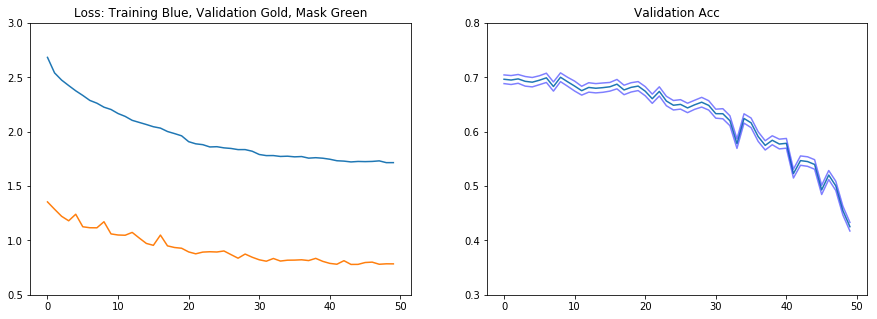

Train loss is: 1.7156132264905681
Validation accuracy is: 0.6964912280701755
Validation loss is: 0.7844978055593692

0.26 hours to completion

12.828732519547145
Final score: 69.53 +- 0.27


In [7]:
# Do the Thing!

start = time.time()
trainlosses, testlosses, acctracker, spreadtracker = [], [], [], []
epochs = 5*epoch
for e in range(epochs):
    # Adjust learnrate
    if e%epoch == 0 and e>0:
        scheduler.step()
    
    # Train for one epoch
    trainloss = train(e, gpu, vbity)
    
    # Evaluate, single pass
    testloss, acc, spread = validate(gpu, vbity, 1, True)
    
    # update the precision graph, report
    display.clear_output(wait=True)
    trainlosses.append(trainloss)
    testlosses.append(testloss)
    acctracker.append(acc)
    spreadtracker.append(spread)
    pl.figure(1, figsize=(15,5))
    pl.subplot(1,2,1)
    pl.plot(trainlosses)
    pl.plot(testlosses)
    pl.ylim((.5,3))
    pl.title("Loss: Training Blue, Validation Gold, Mask Green")
    pl.subplot(1,2,2)
    pl.plot(acctracker[::-1])
    pl.plot(np.array(acctracker[::-1])-np.array(spreadtracker[::-1]), alpha=.5, c='blue')
    pl.plot(np.array(acctracker[::-1])+np.array(spreadtracker[::-1]), alpha=.5, c='blue')
    pl.ylim((0.3,.8))
    pl.title("Validation Acc")
    pl.show()
    print("Train loss is: "+str(trainloss)+
            "\nValidation accuracy is: "+str(acc)+
            "\nValidation loss is: "+str(testloss)+"\n")
    
    print("%.2f hours to completion"%(  (time.time()-start)/(e+1)*(epochs-e)/3600  ))
    print()
print((time.time()-start)/3600) 
_, score, conf = validate(gpu, vbity, 10, False)
print('Final score: %.2f +- %.2f'%(score*100, conf*100))

In [7]:
torch.save(model.state_dict(), 'saved_models/simultaneousmodels.torch')

In [9]:
model = PROTO()
model.load_state_dict(torch.load('saved_models/concurrentpredictionmodel.torch'))
model = model.cuda()

In [ ]:
_, score, conf = validate(gpu, vbity, 10, False)
print('Final score: %.2f +- %.2f'%(score*100, conf*100))

In [11]:
for inp,_ in test_loader:
    break
_,masks = model(inp.cuda(), evalway, trainshot)

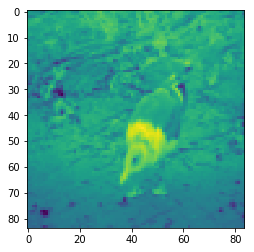

In [27]:
n = 50
pl.imshow(inp[n,0,:,:].data.numpy())

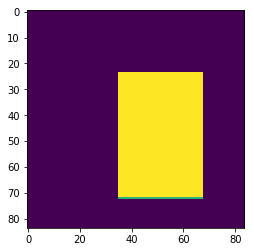

In [28]:
pl.imshow(inp[n,-1,:,:].data.numpy())

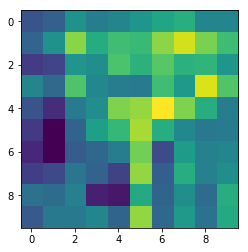

In [29]:
pl.imshow(masks[n,:,:].cpu().data.numpy())